#### This notebook is about SQL database
- Connecting to the Local Database server (later to online DB server)
- Getting the tables from the local database / local files
- Creating Spark Session with JDBC 
- Creating Databases in the server (JDBC driver is not required)
- Creating tables / Views on the Database (The permanent/ temporary tables have different powers)
- Then Work on the regular transformation that was learn in SQL training

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.window import *
from pyspark.sql.functions import *

In [2]:
productPath = "/home/solverbot/spark-warehouse/retail_db/products/part-00000"
orderitemPath = "/home/solverbot/spark-warehouse/retail_db/order_items/part-00000"
ordersPath = "/home/solverbot/spark-warehouse/retail_db/orders/part-00000.txt"

sparkSQL = SparkSession.builder \
       
       .appName("Python Spark SQL basic example") \
       
       .config("spark.jars", "/usr/share/java/postgresql-42.2.26.jar") \
       
       .getOrCreate()

In [3]:
#What is the difference between Session and Context?
#SC is part of the Spark session that is established above
sparkSQL = SparkSession.builder.appName('Spark SQL') \
            .config('spark.jars',"/usr/share/java/postgresql-42.2.26.jar") \
            .getOrCreate()

22/11/22 11:41:47 WARN Utils: Your hostname, codeStation resolves to a loopback address: 127.0.1.1; using 172.17.0.1 instead (on interface docker0)
22/11/22 11:41:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/11/22 11:41:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
sc = sparkSQL.sparkContext
sc

<SparkContext master=local[*] appName=Spark SQL>

In [5]:
from pyspark.sql.functions import *

orders_df = sparkSQL.read \
    
    .format("jdbc") \
    
    .option("url", "jdbc:postgresql://localhost:5432/postgres") \
    
    .option("dbtable", "orders") \
    
    .option("user", "postgres") \
    
    .option("password", 1234) \
    
    .option("driver", "org.postgresql.Driver") \
    
    .load()

In [19]:
sparkSQL.sql("create database if not exists spark_warehouse")

DataFrame[]

In [20]:
sparkSQL.sql("use spark_warehouse")

DataFrame[]

### Below is the connection between the local Postgres Orders, Order_items, Products Table and Pyspark

In [8]:
orderDF = sparkSQL.read.format('jdbc') \
                .option("url", "jdbc:postgresql://localhost:5432/postgres") \
                .option('dbtable','orders') \
                .option('user','postgres') \
                .option('password', 1234) \
                .option('driver','org.postgresql.Driver') \
                .load()

In [9]:
orderItemDF = sparkSQL.read.format('jdbc') \
                .option("url", "jdbc:postgresql://localhost:5432/postgres") \
                .option('dbtable','order_items') \
                .option('user','postgres') \
                .option('password', 1234) \
                .option('driver','org.postgresql.Driver') \
                .load()

In [10]:
productDF = sparkSQL.read.format('jdbc') \
                .option("url", "jdbc:postgresql://localhost:5432/postgres") \
                .option('dbtable','products') \
                .option('user','postgres') \
                .option('password', 1234) \
                .option('driver','org.postgresql.Driver') \
                .load()

In [19]:
productDF.show(2)

+----------+-------------------+--------------------+-------------------+-------------+--------------------+
|product_id|product_category_id|        product_name|product_description|product_price|       product_image|
+----------+-------------------+--------------------+-------------------+-------------+--------------------+
|         1|                  2|Quest Q64 10 FT. ...|                   |        59.98|http://images.acm...|
|         2|                  2|Under Armour Men'...|                   |       129.99|http://images.acm...|
+----------+-------------------+--------------------+-------------------+-------------+--------------------+
only showing top 2 rows



- This commands create local tables after connecting with the database. 
- Now these tables can be modified in any way required
- Then we will see the data written back to postgres DB
- Note one point, the database tables will send its columns along with it

In [12]:
orderDF.createOrReplaceTempView("spark_warehouse.orders")
orderItemDF.createOrReplaceTempView("spark_warehouse.order_items")
productDF.createOrReplaceTempView("spark_warehouse.products")

In [21]:
sparkSQL.sql("show tables").show()

+---------+---------------+-----------+
|namespace|      tableName|isTemporary|
+---------+---------------+-----------+
|         |    order_items|       true|
|         |         orders|       true|
|         |product_revenue|       true|
|         |       products|       true|
+---------+---------------+-----------+



In [34]:
sparkSQL.sql("SELECT * FROM orders").show(2)

+--------+-------------------+-----------------+---------------+
|order_id|         order_date|order_customer_id|   order_status|
+--------+-------------------+-----------------+---------------+
|       1|2013-07-25 00:00:00|            11599|         CLOSED|
|       2|2013-07-25 00:00:00|              256|PENDING_PAYMENT|
+--------+-------------------+-----------------+---------------+
only showing top 2 rows



In [39]:
sparkSQL.sql("SELECT * FROM order_items").show(2)

+-------------+-------------------+---------------------+-------------------+-------------------+------------------------+
|order_item_id|order_item_order_id|order_item_product_id|order_item_quantity|order_item_subtotal|order_item_product_price|
+-------------+-------------------+---------------------+-------------------+-------------------+------------------------+
|            1|                  1|                  957|                  1|             299.98|                  299.98|
|            2|                  2|                 1073|                  1|             199.99|                  199.99|
+-------------+-------------------+---------------------+-------------------+-------------------+------------------------+
only showing top 2 rows



In [35]:
sparkSQL.sql("SELECT * FROM products").show(2)

+----------+-------------------+--------------------+-------------------+-------------+--------------------+
|product_id|product_category_id|        product_name|product_description|product_price|       product_image|
+----------+-------------------+--------------------+-------------------+-------------+--------------------+
|         1|                  2|Quest Q64 10 FT. ...|                   |        59.98|http://images.acm...|
|         2|                  2|Under Armour Men'...|                   |       129.99|http://images.acm...|
+----------+-------------------+--------------------+-------------------+-------------+--------------------+
only showing top 2 rows



In [14]:
o = orderDF.alias("o")
oi = orderItemDF.alias('oi')

In [15]:
#Creating temp view
oi.groupBy("order_item_product_id"). \
    agg(sum('order_item_subtotal'). \
    alias('product_revn')). \
    createTempView('product_revenue')

In [16]:
sparkSQL.sql("SELECT * FROM product_revenue").show(2)

+---------------------+------------------+
|order_item_product_id|      product_revn|
+---------------------+------------------+
|                  897|20566.769999999986|
|                  858| 11799.40999999999|
+---------------------+------------------+
only showing top 2 rows



In [22]:
#This table has been moved to the spark_warehouse database/ namespace
#And the table has been written as files to the local folder
#It is written after the below saveAsTable is executed
sparkSQL.sql("SELECT * FROM product_revenue").write \
        .saveAsTable('product_revenue')

In [17]:
sparkSQL.sql("show tables").show()

+---------+---------------+-----------+
|namespace|      tableName|isTemporary|
+---------+---------------+-----------+
|         |    order_items|       true|
|         |         orders|       true|
|         |product_revenue|       true|
|         |       products|       true|
+---------+---------------+-----------+



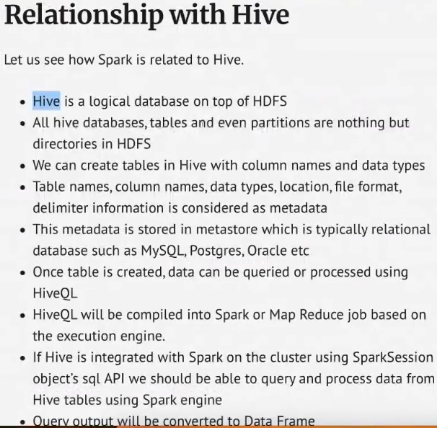

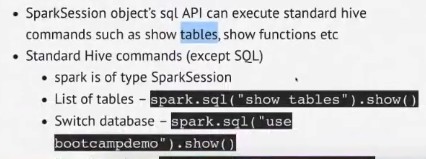

In [50]:
for i in sparkSQL.sql("describe formatted spark_warehouse.product_revenue").collect(): print(i)

Row(col_name='order_item_product_id', data_type='int', comment=None)
Row(col_name='product_revn', data_type='double', comment=None)
Row(col_name='', data_type='', comment='')
Row(col_name='# Detailed Table Information', data_type='', comment='')
Row(col_name='Database', data_type='spark_warehouse', comment='')
Row(col_name='Table', data_type='product_revenue', comment='')
Row(col_name='Created Time', data_type='Tue Nov 22 09:50:07 IST 2022', comment='')
Row(col_name='Last Access', data_type='UNKNOWN', comment='')
Row(col_name='Created By', data_type='Spark 3.3.1', comment='')
Row(col_name='Type', data_type='MANAGED', comment='')
Row(col_name='Provider', data_type='parquet', comment='')
Row(col_name='Location', data_type='file:/run/media/solverbot/repoA/gitFolders/moreDE/spark-warehouse/spark_warehouse.db/product_revenue', comment='')


In [54]:
for f in sparkSQL.sql('show functions').take(15): print(f)

Row(function='!')
Row(function='!=')
Row(function='%')
Row(function='&')
Row(function='*')
Row(function='+')
Row(function='-')
Row(function='/')
Row(function='<')
Row(function='<=')
Row(function='<=>')
Row(function='<>')
Row(function='=')
Row(function='==')
Row(function='>')


In [60]:
for f in sparkSQL.sql("show functions 'abs'").collect(): print(f)

Row(function='abs')


In [23]:
help(sparkSQL.read.table)

Help on method table in module pyspark.sql.readwriter:

table(tableName: str) -> 'DataFrame' method of pyspark.sql.readwriter.DataFrameReader instance
    Returns the specified table as a :class:`DataFrame`.
    
    .. versionadded:: 1.4.0
    
    Parameters
    ----------
    tableName : str
        string, name of the table.
    
    Examples
    --------
    >>> df = spark.read.parquet('python/test_support/sql/parquet_partitioned')
    >>> df.createOrReplaceTempView('tmpTable')
    >>> spark.read.table('tmpTable').dtypes
    [('name', 'string'), ('year', 'int'), ('month', 'int'), ('day', 'int')]



In [24]:
readPdtRevenue = sparkSQL.read.parquet('spark-warehouse/spark_warehouse.db/product_revenue/')
readPdtRevenue.createOrReplaceTempView('newTable')

In [25]:
readPdtRevenue.show(1)

+---------------------+------------------+
|order_item_product_id|      product_revn|
+---------------------+------------------+
|                  897|20566.769999999986|
+---------------------+------------------+
only showing top 1 row



In [28]:
sparkSQL.sql("SELECT * FROM orders WHERE order_status not in ('COMPLETE','CLOSED')").take(5)

[Row(order_id=2, order_date=datetime.datetime(2013, 7, 25, 0, 0), order_customer_id=256, order_status='PENDING_PAYMENT'),
 Row(order_id=8, order_date=datetime.datetime(2013, 7, 25, 0, 0), order_customer_id=2911, order_status='PROCESSING'),
 Row(order_id=9, order_date=datetime.datetime(2013, 7, 25, 0, 0), order_customer_id=5657, order_status='PENDING_PAYMENT'),
 Row(order_id=10, order_date=datetime.datetime(2013, 7, 25, 0, 0), order_customer_id=5648, order_status='PENDING_PAYMENT'),
 Row(order_id=11, order_date=datetime.datetime(2013, 7, 25, 0, 0), order_customer_id=918, order_status='PAYMENT_REVIEW')]

In [32]:
sparkSQL.sql("SELECT * FROM orders WHERE order_status IN ('COMPLETE','CLOSED') AND order_date LIKE '2013-12%'").show(2)

+--------+-------------------+-----------------+------------+
|order_id|         order_date|order_customer_id|order_status|
+--------+-------------------+-----------------+------------+
|   20916|2013-12-01 00:00:00|            11503|      CLOSED|
|   20919|2013-12-01 00:00:00|              383|    COMPLETE|
+--------+-------------------+-----------------+------------+
only showing top 2 rows



In [33]:
sparkSQL.sql("SELECT * FROM order_items WHERE order_item_subtotal != order_item_quantity * order_item_product_price").show(2)

+-------------+-------------------+---------------------+-------------------+-------------------+------------------------+
|order_item_id|order_item_order_id|order_item_product_id|order_item_quantity|order_item_subtotal|order_item_product_price|
+-------------+-------------------+---------------------+-------------------+-------------------+------------------------+
|           33|                 11|                 1014|                  5|              249.9|                   49.98|
|           84|                 29|                 1014|                  5|              249.9|                   49.98|
+-------------+-------------------+---------------------+-------------------+-------------------+------------------------+
only showing top 2 rows



In [34]:
sparkSQL.sql("SELECT * FROM order_items WHERE order_item_order_id in (SELECT order_id FROM orders WHERE order_status == 'COMPLETE')").show(2)

+-------------+-------------------+---------------------+-------------------+-------------------+------------------------+
|order_item_id|order_item_order_id|order_item_product_id|order_item_quantity|order_item_subtotal|order_item_product_price|
+-------------+-------------------+---------------------+-------------------+-------------------+------------------------+
|         1129|                463|                  365|                  4|             239.96|                   59.99|
|         1130|                463|                  502|                  5|              250.0|                    50.0|
+-------------+-------------------+---------------------+-------------------+-------------------+------------------------+
only showing top 2 rows



In [35]:
sparkSQL.sql("SELECT * FROM order_items WHERE order_item_order_id not in (SELECT order_id FROM orders WHERE order_status == 'COMPLETE')").show(2)

+-------------+-------------------+---------------------+-------------------+-------------------+------------------------+
|order_item_id|order_item_order_id|order_item_product_id|order_item_quantity|order_item_subtotal|order_item_product_price|
+-------------+-------------------+---------------------+-------------------+-------------------+------------------------+
|            1|                  1|                  957|                  1|             299.98|                  299.98|
|            2|                  2|                 1073|                  1|             199.99|                  199.99|
+-------------+-------------------+---------------------+-------------------+-------------------+------------------------+
only showing top 2 rows



In [40]:
sparkSQL.sql("""SELECT * FROM orders o LEFT OUTER JOIN order_items oi 
                ON o.order_id = oi.order_item_order_id
                WHERE oi.order_item_order_id IS NULL""").count()

11452

In [41]:
sparkSQL.sql("""SELECT * FROM orders o RIGHT OUTER JOIN order_items oi 
                ON o.order_id = oi.order_item_order_id
                WHERE oi.order_item_order_id IS NULL""").count()

0

In [43]:
sparkSQL.sql("""SELECT order_item_order_id, SUM(order_item_subtotal) order_total FROM order_items
                GROUP BY order_item_order_id""").show(5)

+-------------------+------------------+
|order_item_order_id|       order_total|
+-------------------+------------------+
|                148|            479.99|
|                463| 829.9200000000001|
|                471|169.98000000000002|
|                496|441.95000000000005|
|               1088|249.97000000000003|
+-------------------+------------------+
only showing top 5 rows



In [44]:
sparkSQL.sql("""SELECT order_item_order_id, SUM(order_item_subtotal) FROM order_items
                GROUP BY order_item_order_id""").write.saveAsTable('order_ids_revenue')

In [51]:
sparkSQL.sql("""SELECT order_item_order_id, SUM(order_item_subtotal) order_total FROM order_items
                GROUP BY order_item_order_id
                HAVING SUM(order_item_subtotal) > 250
                ORDER BY order_total DESC""").show(5)

+-------------------+------------------+
|order_item_order_id|       order_total|
+-------------------+------------------+
|              68703|3449.9100000000003|
|              68724|2859.8900000000003|
|              68858|           2839.91|
|              68809|           2779.86|
|              68766|            2699.9|
+-------------------+------------------+
only showing top 5 rows



#### Touching on the Ranking, Partitioning in this file itself

In [57]:
sparkSQL.sql("""SELECT DISTINCT order_item_order_id, SUM(order_item_subtotal)
                    OVER (PARTITION BY order_item_order_id) AS order_total
                    FROM order_items""").show(5)

+-------------------+------------------+
|order_item_order_id|       order_total|
+-------------------+------------------+
|                  1|            299.98|
|                  2|            579.98|
|                  4|            699.85|
|                  5|1129.8600000000001|
|                  7| 579.9200000000001|
+-------------------+------------------+
only showing top 5 rows



In [65]:
sparkSQL.sql("""SELECT order_item_order_id, order_item_product_id, SUM(order_item_subtotal)
                    OVER (PARTITION BY order_item_order_id) AS order_total,
                    AVG(order_item_subtotal)
                    OVER (PARTITION BY order_item_order_id) order_avg
                    FROM order_items""").show(5)

+-------------------+---------------------+-----------+------------------+
|order_item_order_id|order_item_product_id|order_total|         order_avg|
+-------------------+---------------------+-----------+------------------+
|                  1|                  957|     299.98|            299.98|
|                  2|                 1073|     579.98|193.32666666666668|
|                  2|                  502|     579.98|193.32666666666668|
|                  2|                  403|     579.98|193.32666666666668|
|                  4|                  897|     699.85|          174.9625|
+-------------------+---------------------+-----------+------------------+
only showing top 5 rows



In [72]:
sparkSQL.sql("""SELECT oi.order_item_product_id, 
                    oi.order_item_subtotal, o.order_date,
                    RANK() OVER (PARTITION BY o.order_date 
                                    ORDER BY oi.order_item_subtotal DESC) order_rank
                    FROM orders o JOIN order_items oi 
                    ON o.order_id==oi.order_item_order_id""").show(15)

+---------------------+-------------------+-------------------+----------+
|order_item_product_id|order_item_subtotal|         order_date|order_rank|
+---------------------+-------------------+-------------------+----------+
|                  226|             599.99|2013-07-25 00:00:00|         1|
|                  191|             499.95|2013-07-25 00:00:00|         2|
|                  191|             499.95|2013-07-25 00:00:00|         2|
|                  191|             499.95|2013-07-25 00:00:00|         2|
|                  191|             499.95|2013-07-25 00:00:00|         2|
|                  191|             499.95|2013-07-25 00:00:00|         2|
|                  191|             499.95|2013-07-25 00:00:00|         2|
|                  191|             499.95|2013-07-25 00:00:00|         2|
|                  191|             499.95|2013-07-25 00:00:00|         2|
|                  191|             499.95|2013-07-25 00:00:00|         2|
|                  191|  

In [74]:
sparkSQL.sql("""SELECT oi.order_item_product_id, 
                    oi.order_item_subtotal, o.order_date,
                    DENSE_RANK() OVER (PARTITION BY o.order_date 
                                    ORDER BY oi.order_item_subtotal DESC) order_rank
                    FROM orders o JOIN order_items oi 
                    ON o.order_id==oi.order_item_order_id""").show(15)

+---------------------+-------------------+-------------------+----------+
|order_item_product_id|order_item_subtotal|         order_date|order_rank|
+---------------------+-------------------+-------------------+----------+
|                  226|             599.99|2013-07-25 00:00:00|         1|
|                  191|             499.95|2013-07-25 00:00:00|         2|
|                  191|             499.95|2013-07-25 00:00:00|         2|
|                  191|             499.95|2013-07-25 00:00:00|         2|
|                  191|             499.95|2013-07-25 00:00:00|         2|
|                  191|             499.95|2013-07-25 00:00:00|         2|
|                  191|             499.95|2013-07-25 00:00:00|         2|
|                  191|             499.95|2013-07-25 00:00:00|         2|
|                  191|             499.95|2013-07-25 00:00:00|         2|
|                  191|             499.95|2013-07-25 00:00:00|         2|
|                  191|  